In [1]:
import psql_database as db
from settings.connection_settings import mqtt_settings as settings
from settings.connection_settings import openWeatherMap_settings as api_settings
from settings.crop_settings import water
from sqlalchemy.orm import sessionmaker
from datetime import datetime,timedelta

In [35]:
import pandas as pd
import numpy as np

In [3]:
engine = db.engine
Session = sessionmaker(engine)
session = Session()

In [18]:
query = session.query(db.predictedEto.date,db.predictedEto.predicted_eto,db.predictedEto.forecast_horizon).filter(db.predictedEto.forecast_horizon==1).order_by(db.predictedEto.date.desc())
query_7 = session.query(db.predictedEto.date,db.predictedEto.predicted_eto,db.predictedEto.forecast_horizon).filter(db.predictedEto.forecast_horizon==7).order_by(db.predictedEto.date.desc())

In [26]:
date = []
y_pred_one = []
y_pred_seven = []
forecast_horizon = []
et_o = []
et_o_date = []
for item in query:
    date.append(item[0])
    y_pred_one.append(item[1])
    forecast_horizon.append(item[2])


In [27]:
eto = session.query(db.computedEto.date,db.computedEto.computed_eto).order_by(db.computedEto.date.desc())

In [28]:
for et in eto:
    et_o_date.append(et[0])
    et_o.append(et[1])

In [22]:
df = pd.DataFrame({'Data': et_o_date,'Eto':et_o})

In [16]:
df = df[:31].set_index('Data')

In [17]:
df.to_csv('C:/Users/Naisaile/Documents/PROYECTO-TESIS/Evapotranspiration-Prediction-2022/API/data/prototype-eto.csv')

In [29]:
y_date = []
for i in range(len(date)):
    y_date.append(date[i] + timedelta(days=forecast_horizon[i]))

In [30]:
et_o_date = et_o_date[:30]
et_o = et_o[:30]

In [31]:
et_o_date = et_o_date[:-1]
et_o = et_o[:-1]

In [32]:
y_date = y_date[2:]
y_pred_one = y_pred_one[2:]

In [33]:
df = pd.DataFrame({'date': y_date,'observed_eto': et_o,'predicted_eto_oneday': y_pred_one})

In [36]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(df['observed_eto'],df['predicted_eto_oneday'])
rmse = mean_squared_error(df['observed_eto'],df['predicted_eto_oneday'],squared=False)
nrmse = rmse/(np.mean(np.array(df['observed_eto'].values)))

In [37]:
nrmse

0.21243032897591235

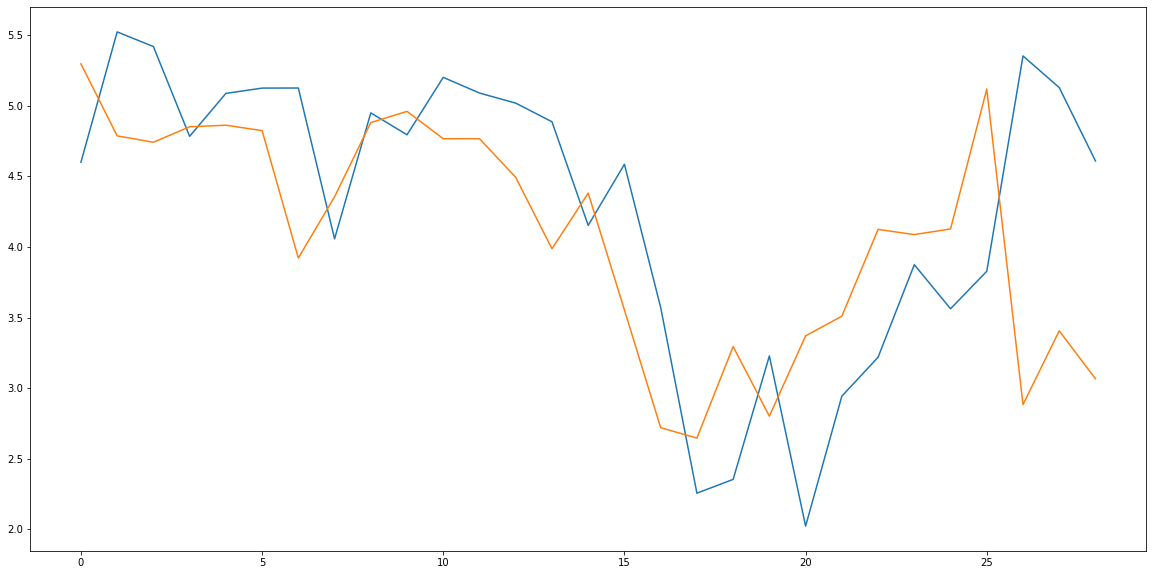

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(et_o)
plt.plot(y_pred_one)


In [38]:
def compute_irrigation_value(computed_eto):
    id_plant = session.query(db.Plant.id_plant).filter(db.Plant.name == 'peppermint')[0][0]
    kc_ini = session.query(db.Plant.kc_ini).filter(db.Plant.id_plant == id_plant)[0][0]
    kc_med = session.query(db.Plant.kc_med).filter(db.Plant.id_plant == id_plant)[0][0]
    a = session.query(db.Crop.a).filter(db.Crop.id_plant == id_plant)[0][0]
    pc = session.query(db.Crop.pc).filter(db.Crop.id_plant == id_plant)[0][0]
    er = session.query(db.Crop.er).filter(db.Crop.id_plant == id_plant)[0][0]
    water_demand = ((computed_eto*((kc_ini+kc_med)/2)*a*(pc/100))/er)*1000
    return water_demand

In [56]:

fecha = '31-10-2022'
fecha = datetime.strptime(fecha, '%d-%m-%Y')
water_data = session.query(db.waterAmount.date,db.waterAmount.water_amount).filter(db.waterAmount.date >= fecha).order_by(db.waterAmount.date.desc())
water_data_et = session.query(db.computedEto.date,db.computedEto.computed_eto).filter(db.computedEto.date >= fecha).order_by(db.computedEto.date.desc())
array_date = []
array_water = []
array_water_et = []
for row in water_data:
                array_date.append(row[0].strftime('%d-%m-%Y'))
                array_water.append(round(row[1],1))
for row in water_data_et:
    array_water_et.append(round(compute_irrigation_value(row[1]),1))


In [60]:
df = pd.DataFrame({"Date": array_date,"Water":array_water,"Water_et":array_water_et})

In [61]:
df

,Date,Water,Water_et
0,29-11-2022,0.0,44.7
1,28-11-2022,1.1,53.7
2,27-11-2022,25.0,52.7
3,26-11-2022,1.1,46.5
4,25-11-2022,4.8,49.5
5,24-11-2022,3.2,49.8
6,23-11-2022,8.2,49.8
7,22-11-2022,0.8,39.5
8,21-11-2022,15.4,48.1
9,20-11-2022,7.4,46.6


In [68]:
array_date = []
array_temperature = []
array_humidity = []
array_soil1 = []
array_soil2 = []
array_soil3 = []
data = session.query(db.Sensor.datetime,db.Sensor.temperature,db.Sensor.humidity,db.Sensor.soilMoisture1,db.Sensor.soilMoisture2,db.Sensor.soilMoisture3).filter(db.Sensor.datetime >= fecha).order_by(db.Sensor.datetime.desc())
for row in data:
    array_date.append(row[0].strftime('%Y-%m-%d %H:%M:%S'))
    array_temperature.append(row[1])
    array_humidity.append(row[2])
    array_soil1.append(row[3])
    array_soil2.append(row[4])
    array_soil3.append(row[5])
df = pd.DataFrame({"Date": array_date,"Temperature":array_temperature,"Humidity":array_humidity,"Soil1":array_soil1,"Soil2":array_soil2,"Soil3":array_soil3})
df.Date = pd.to_datetime(pd.to_datetime(df.Date,format='%Y-%m-%d').dt.strftime('%Y-%m-%d %H'),format='%Y-%m-%d')
df_avg = df[["Temperature","Humidity","Soil1","Soil2","Soil3"]].groupby(df["Date"].sort_values()).mean().round(1)
df_avg = df_avg.interpolate()
df_avg.index = df_avg.index.strftime('%d-%m-%Y %H:%M')
num = []
for i in range(len(df_avg)):
    num.append(i)
df_avg_j = pd.DataFrame({"index": num,"Date": df_avg.index,"Temperature": df_avg['Temperature'],"Humidity": df_avg['Humidity'],"Soil1": df_avg['Soil1'],"Soil2": df_avg['Soil2'],"Soil3": df_avg['Soil3']}).set_index('Date')

In [75]:
df_avg_j.to_csv('C:/Users/Naisaile/Documents/PROYECTO-TESIS/Evapotranspiration-Prediction-2022/API/data/historical-data-prototype.csv')

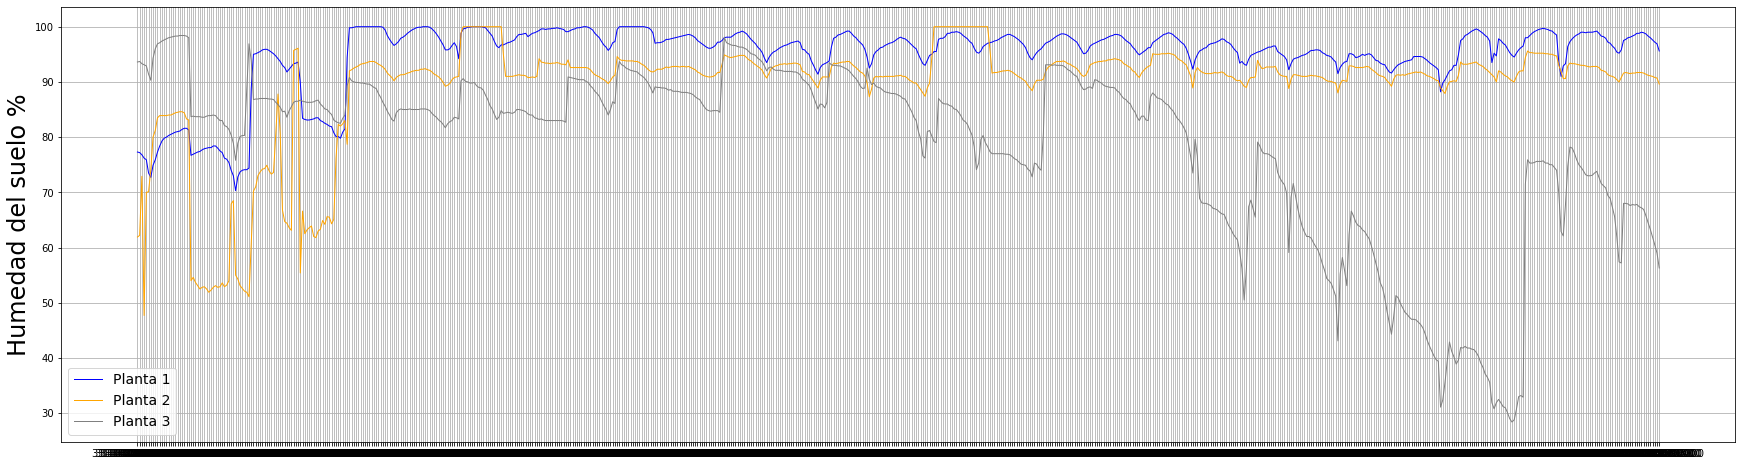

In [74]:
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=[30,8])
plt.grid()
plt.plot(df_avg_j['Soil1'],'-', color = 'blue', ms=4, lw=1, alpha=1, label='Planta 1')
plt.plot(df_avg_j['Soil2'],'-', color = 'orange', ms=4, lw=1, alpha=1, label='Planta 2')
plt.plot(df_avg_j['Soil3'],'-', color = 'gray', ms=4, lw=1, alpha=1, label='Planta 3')
# plt.tick_params(labelsize=20)
plt.legend(fontsize=14)
# plt.xlabel("Días", fontsize=24)
plt.ylabel("Humedad del suelo %", fontsize=24);